In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
warnings.filterwarnings('ignore')

In [3]:
ticker = yf.Ticker('TATAMOTORS.NS')
data = ticker.history(start= '2012-07-15', end= '2022-07-21')
print(data.shape)

(2468, 7)


In [ ]:
dataset = data.filter(['Close']).values
training_size = int(len(dataset) * 0.75)
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size - 90:, :]
x_train, y_train, x_test, y_test = [], [], [], dataset[training_size:, :]

In [4]:
ticker = yf.Ticker('TATAMOTORS.NS')
data = ticker.history(start= '2012-07-15', end= '2022-07-21')
print(data.shape)

# Extracting Values :- 
dataset = data.filter(['Close']).values
print(dataset.shape)

# Normalizing the data :- 
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

# Setting up training size :- 
training_size = int(len(dataset) * 0.75)

# Creating Training data :- 
train_data = scaled_data[:training_size]

# Creating Testing data :- 
test_data = scaled_data[training_size - 90:, :]

# Creating x_train, y_train, x_test, y_test dataset :- 
x_train, y_train, x_test, y_test = [], [], [], dataset[training_size:, :]

for i in range(90, len(train_data)):
    x_train.append(train_data[i - 90: i, 0])
    y_train.append(train_data[i, 0])
    
for j in range(90, len(test_data)):
    x_test.append(test_data[j - 90:j, 0])

# Converting list into arrays:- 
x_train, y_train, x_test = np.array(x_train), np.array(y_train), np.array(x_test)

# Reshaping x_train & x_test to 3 dimensions for LSTM model :- 
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print(x_train.shape, x_test.shape)

(2468, 7)
(2468, 1)
(1761, 90, 1) (617, 90, 1)


### Model Building :- 

In [5]:
# Sequential Model Building :- 
model = Sequential()
model.add(LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss= 'mean_squared_error', optimizer= 'adam')

# Training the model :- 
model.fit(x_train, y_train, batch_size= 3, epochs= 7)

Epoch 1/7
587/587 [==============================] - 45s 54ms/step - loss: 0.0066
Epoch 2/7
587/587 [==============================] - 30s 52ms/step - loss: 0.0012
Epoch 3/7
587/587 [==============================] - 31s 53ms/step - loss: 9.3254e-04
Epoch 4/7
587/587 [==============================] - 30s 52ms/step - loss: 8.9945e-04
Epoch 5/7
587/587 [==============================] - 31s 52ms/step - loss: 6.6022e-04
Epoch 6/7
587/587 [==============================] - 33s 56ms/step - loss: 6.6615e-04
Epoch 7/7
587/587 [==============================] - 35s 60ms/step - loss: 5.0163e-04


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


### Validation :- 

In [7]:
# Predictions of x_test :-
predictions = model.predict(x_test)

# Transforming the values to its original form :- 
predictions = scaler.inverse_transform(predictions)

# Evaluating the model with RMSE :- 
print('RMSE Value :- ', np.sqrt(mean_squared_error(predictions, y_test)))

20/20 [==============================] - 3s 31ms/step
RMSE Value :-  11.102989874963502


In [8]:
Train = data[:training_size]
Validation = data[training_size:]
Validation['Prediction'] = predictions

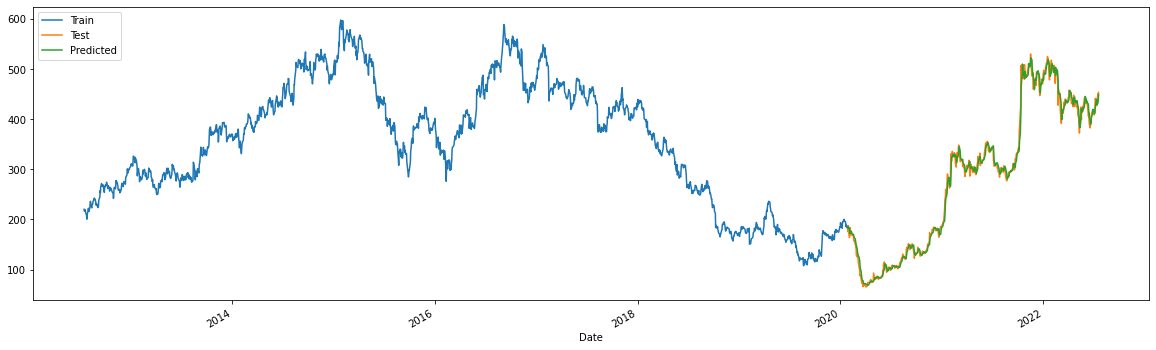

In [9]:
plt.figure(figsize = (20,6))
Train.Close.plot(label= 'Train');
Validation.Close.plot(label = 'Test');
Validation.Prediction.plot(label = 'Predicted');
plt.legend(loc= 'upper left');

### Saving the Model :- 

In [10]:
model.save('stock_prediction.h5')

### Forecasting Future Prices :- 

In [11]:
period = 10

In [12]:
initial_data = [i for i in data['Close'].values]


for i in np.arange(period):
    in_array = np.array(initial_data[-90:]).reshape(-1,1)
    scaled_in = scaler.fit_transform(in_array)
    values = np.array(scaled_in).reshape(1,-1)
    values = values.reshape(values.shape[0], values.shape[1], 1)
    pred = model.predict(values)
    inverse = scaler.inverse_transform(pred)
    initial_data.extend(inverse[0].tolist())

print(initial_data[-period:])

1/1 [==============================] - 0s 46ms/step
[452.6272888183594, 453.5279235839844, 453.32977294921875, 452.6172790527344, 451.6864929199219, 450.7278747558594, 449.8606872558594, 449.14764404296875, 448.6092224121094, 448.2373962402344]


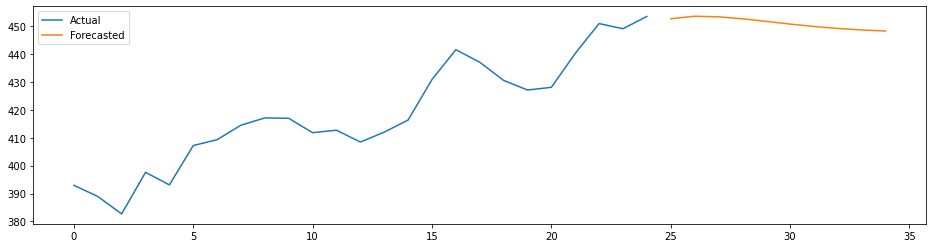

In [13]:
data_range = int(period * 2.5)
plt.figure(figsize= (16,4))
plt.plot(scaley= False, )
plt.plot(range(data_range), data.Close[-data_range:], label= 'Actual');
plt.plot(range(data_range, data_range + period), initial_data[-period:], label = 'Forecasted');
plt.legend(loc= 'upper left');